In [1]:
# Fetch country GIS files from Global Administrative Areas (GADM)

In [2]:
import geopandas as gpd
import requests
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import shutil

In [3]:
# Function to fetch country list and codes
def fetch_country_list(url="https://gadm.org/download_country.html"):
    response = requests.get(url)
    response.encoding = 'utf-8'  # Ensure UTF-8 encoding
    soup = BeautifulSoup(response.text, 'html.parser')
    countries_menu = soup.find_all('option')
    country_list = [
        {
            'abbr': value.split('_')[0],
            'name': value.split('_')[1],
            'code': value.split('_')[2]
        }
        for country in countries_menu if (value := country.get('value'))
    ]
    return pd.DataFrame(country_list)

In [4]:
# Function to create country-specific directory
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [5]:
# Function to download and extract shapefiles
def download_and_extract_shapefiles(country_abbr, country_name, base_path="../data/raw"):
    url = f"https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_{country_abbr}_shp.zip"
    country_dir = os.path.join(base_path, country_name)
    zip_path = os.path.join(country_dir, f"gadm41_{country_abbr}_shp.zip")
    extract_path = os.path.join(country_dir, f"gadm41_{country_abbr}_shp")

    create_directory(country_dir)

    # Download file
    print(f"Downloading shapefiles for {country_name}...")
    response = requests.get(url)
    with open(zip_path, "wb") as file:
        file.write(response.content)
    print("Download complete!")

    # Extract files
    print("Extracting files...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete!")

    return zip_path, extract_path

In [6]:
# Function to clean column names
def clean_columns(gdf):
    gdf.columns = [col.split('_')[0].lower() for col in gdf.columns]
    return gdf

In [7]:
# Function to load and clean shapefiles
def load_shapefiles(extract_path, country_abbr):
    paths = {
        "country": os.path.join(extract_path, f"gadm41_{country_abbr}_0.shp"),
        "state": os.path.join(extract_path, f"gadm41_{country_abbr}_1.shp"),
        "municipality": os.path.join(extract_path, f"gadm41_{country_abbr}_2.shp"),
    }
    gdfs = {key: clean_columns(gpd.read_file(path)) for key, path in paths.items()}
    return gdfs

In [8]:
# Function to plot the geography levels
def plot_geography(gdfs):
    for level, gdf in gdfs.items():
        fig, ax = plt.subplots(1, 1, figsize=(15, 7))
        gdf.plot(ax=ax, color="#e9e9e9", edgecolor="#b1b1b1", linewidth=0.3)
        ax.set_title(f"{level.capitalize()} Level", fontsize=14)
        ax.axis("off")
        plt.show()

In [9]:
# Function to clean up files
def clean_up(zip_path, extract_path):
    print("Cleaning up temporary files...")
    os.remove(zip_path)
    shutil.rmtree(extract_path)
    print("Cleanup complete!")

In [10]:
# Main workflow
def main(country_name):
    print("Fetching country list...")
    df = fetch_country_list()

    # Get country abbreviation and name
    try:
        country_abbr = df.query(f'name == "{country_name}"')['abbr'].iloc[0]
        country_name_str = df.query(f'name == "{country_name}"')['name'].iloc[0]
    except IndexError:
        print(f"Country '{country_name}' not found in the list.")
        return

    # Download and extract shapefiles
    zip_path, extract_path = download_and_extract_shapefiles(country_abbr, country_name_str)

    # Load and clean shapefiles
    gdfs = load_shapefiles(extract_path, country_abbr)

    # Plot the geography levels
    plot_geography(gdfs)

    # Cleanup
    clean_up(zip_path, extract_path)

Fetching country list...
Download complete!
Extracting files...
Extraction complete!


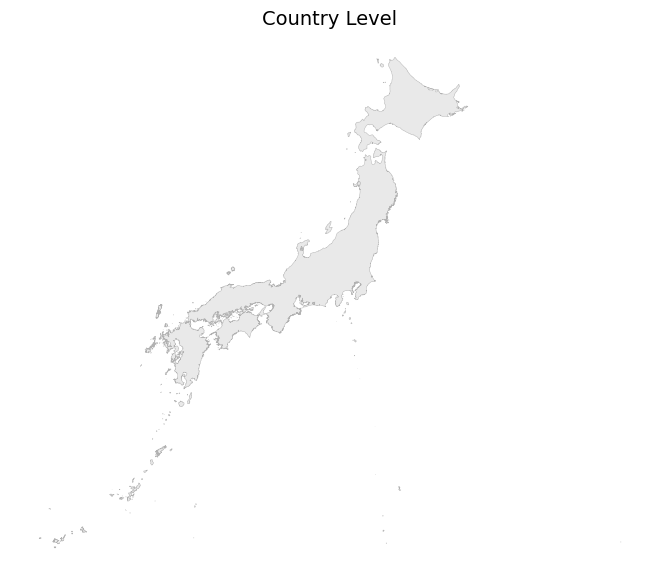

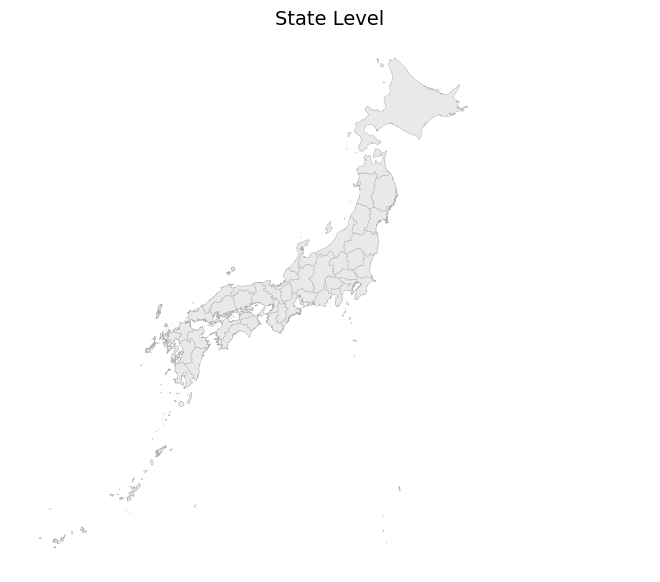

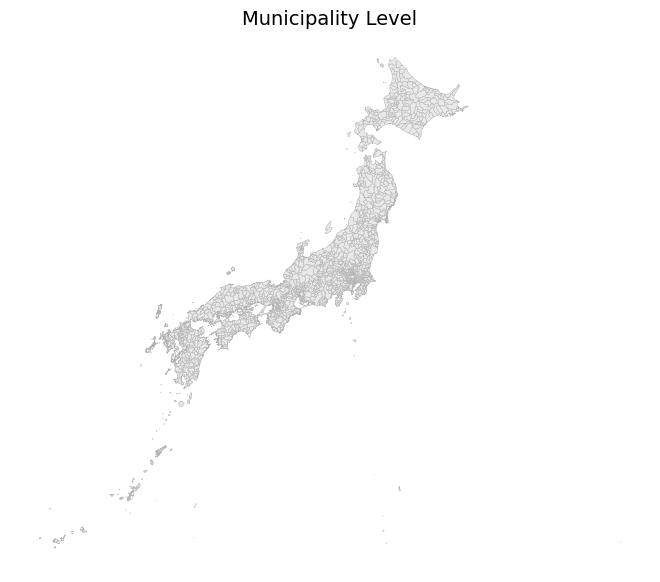

Cleaning up temporary files...
Cleanup complete!


In [12]:
# Run the workflow for a specific country
main("Japan")